# 全投票データ、メタデータをJSONオブジェクトとしてロード

In [122]:
# JSON形式の時系列データをPandasで分析しplotする。メタデータも用意されているのでjson_normalizeも利用。
import json 
import pandas as pd
import datetime
import matplotlib
from pandas.io.json import json_normalize

%matplotlib inline

a =  open('./data.min.json','rt',encoding='utf-8')
metadata =  open('./meta.min.json','rt',encoding='utf-8')
#メタデータをJSONオブジェクトとしてロード
raw_meta = json.load(metadata)
#全投票データをJSONオブジェクトとしてロード
raw_data = json.load(a)
#メタデータをDataFrame化。コード（アイドルや役の番号）と値（アイドル名、役名）の辞書を取得。
df_mata = raw_meta['dramas']
#df_metaからrolesをキーとして抽出したものをDataFrame化。
df_roles = pd.io.json.json_normalize(df_mata, record_path='roles')
#idをインデックスとして利用。（id=16のnameは主人公、17は友達、18は先生、、、等。）
df_roles.index = df_roles.pop('id')
#役の番号と役名の辞書を取得
dict_roles = df_roles.to_dict()['name']
#アイドルのIDとアイドル名の辞書も取得
df_idols = pd.io.json.json_normalize(raw_meta, record_path='candidates')
df_idols.index = df_idols.pop('id')
dict_idols =df_idols.to_dict()['name']

### アイドル、役ごとに1時間単位で集計した投票数をデータフレームに格納

In [123]:
#作りたいデータフレームの列たちをリストで定義。アイドル、役ごとに1時間単位で集計した投票数
cols_vote_at_this_hour = ['hour', 'idol_id', 'role_id', 'vote_at_this_time']
#列はさっき作ったリスト、インデックスは無しで、空のデータフレームを作成。
df_vote_at_this_hour = pd.DataFrame(index=[], columns=cols_vote_at_this_hour)

#アイドルIDごと
for id in df_idols.index :
    #全投票データから1行ずつEOFまで
    for data_role in raw_data :
        role = data_role['role_id']  #役ID
        logs = data_role['logs']     #logs（集計単位）
        #logsオブジェクト（集計日時「date」とランキングオブジェクト「ranking」）を、rankingをキーにデータフレーム化する
        df_lile = pd.io.json.json_normalize(logs, record_path='ranking', meta=['date'])
        # ISO 8601 の拡張形式の時刻をpandasで使いやすいdatetime形式に変換しておく。
        df_lile['date'] = df_lile['date'].map(lambda x: datetime.datetime.strptime(x, '%Y-%m-%dT%H:%M:%S+09:00')) 
        #対象のアイドルIDのデータフレームを選択
        df_lile = df_lile[df_lile['idol_id'] == id]
        #時間帯で集計するために、時間をindexにする。
        df_lile.index = pd.to_datetime(df_lile.index, format='%Y-%m-%d')
        df_lile.set_index(['date'], inplace=True)
        df_lile['vote_at_this_time'] = (df_lile['votes'] - df_lile['votes'].shift(1)).fillna(0)
        #時刻をhourに変換
        df_lile['hour'] = list(pd.Series(df_lile.index).apply(lambda x: x.hour))
        #hourで集計
        hour_df = pd.DataFrame(df_lile.groupby('hour').sum())
        #累計のvoteは使わないのでdrop
        hour_df = hour_df.drop('votes', axis=1)
        #添字をアイドルIDとして利用
        hour_df["idol_id"] = id
        #roleをrole_idとして利用
        hour_df["role_id"] = role
        #インデックスなしのデータフレームに追加するため、インデックスをリセット
        hour_df = hour_df.reset_index()
        #データフレームに追加
        df_vote_at_this_hour = df_vote_at_this_hour.append(hour_df)

        

### すべての役の獲得票を合算する

In [124]:
df_vote_at_this_hour = df_vote_at_this_hour.drop("role_id",axis=1)
df_vote_at_this_hour_allrole = pd.DataFrame(df_vote_at_this_hour.groupby(['hour',"idol_id"]).sum())
##['hour',"idol_id"]でgroupbyすると['hour',"idol_id"]のマルチインデックスになる
##見たい場合はdf_vote_at_this_hour_allrole.loc[(0)]でテーブルを持ってきたり[(0,1)]でセルを持ってきたりできる

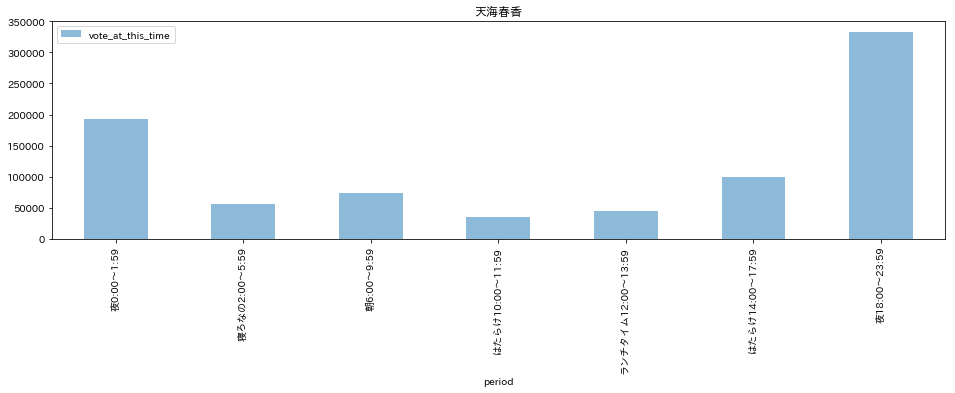

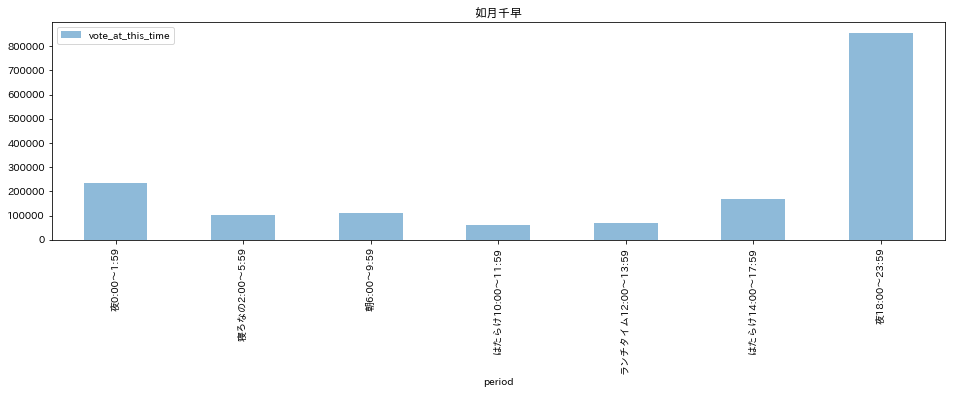

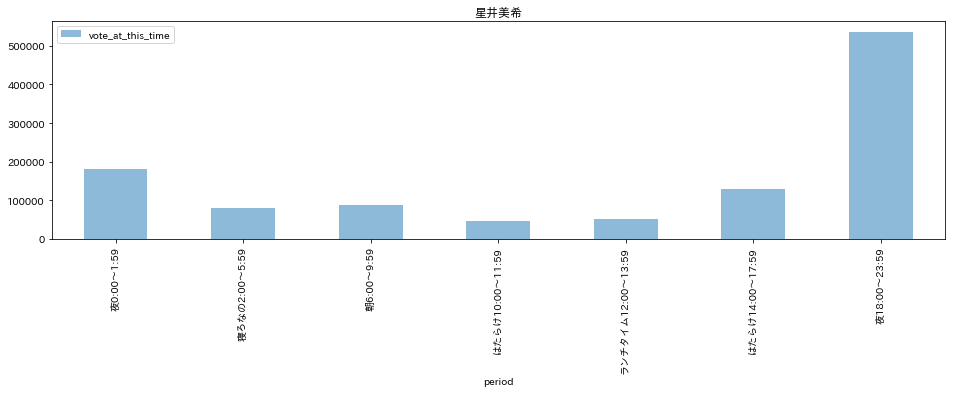

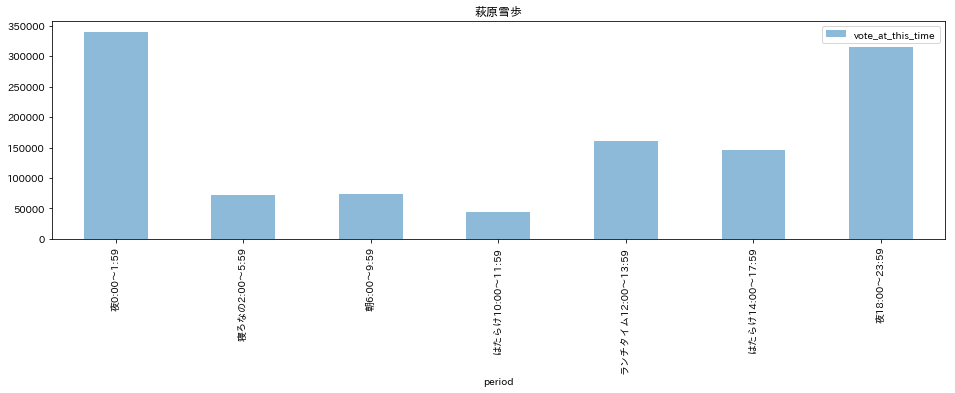

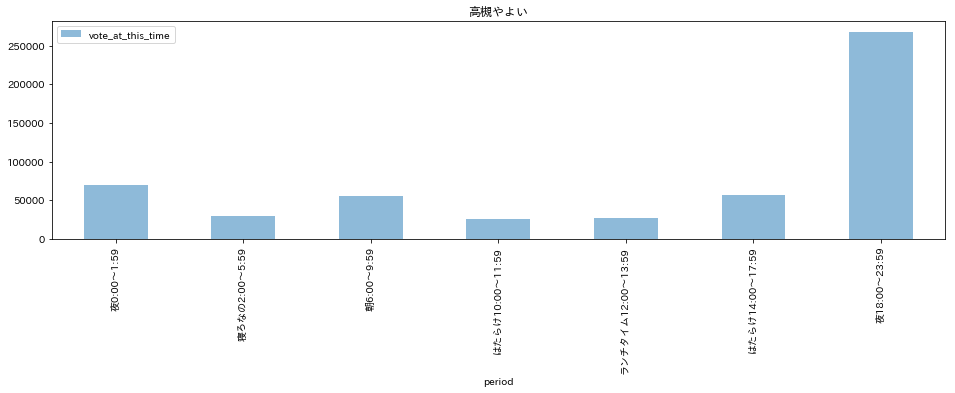

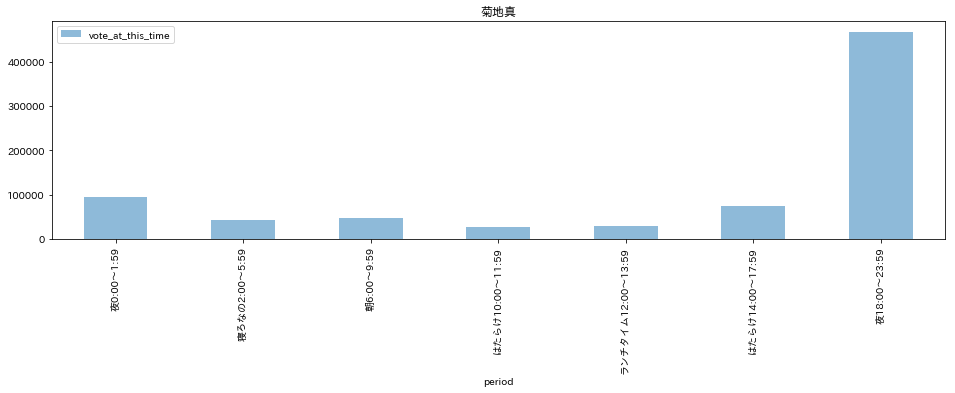

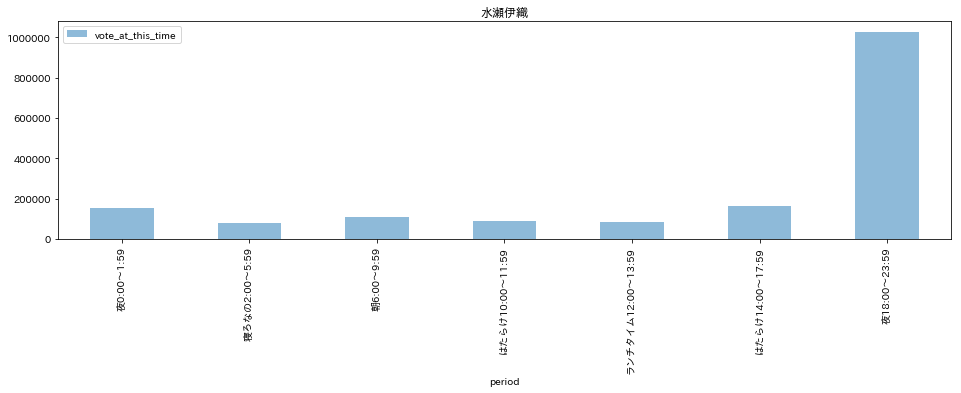

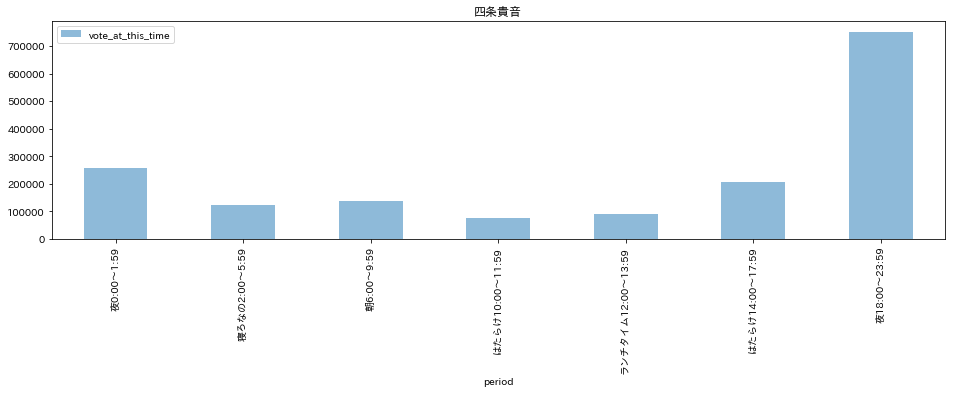

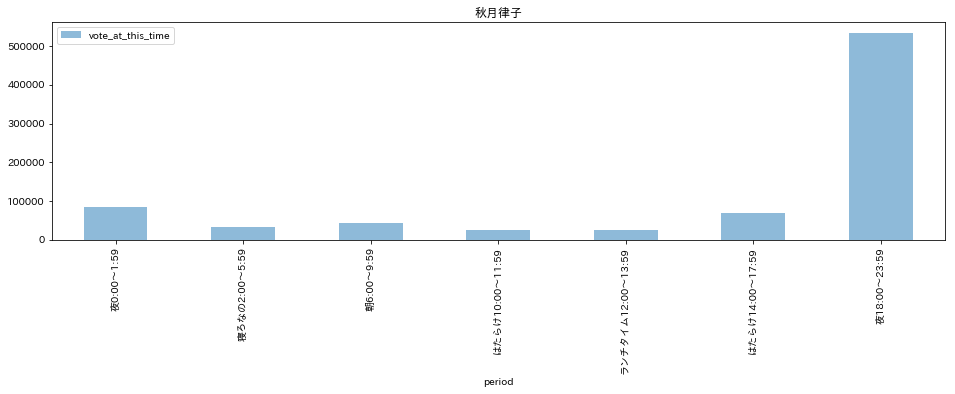

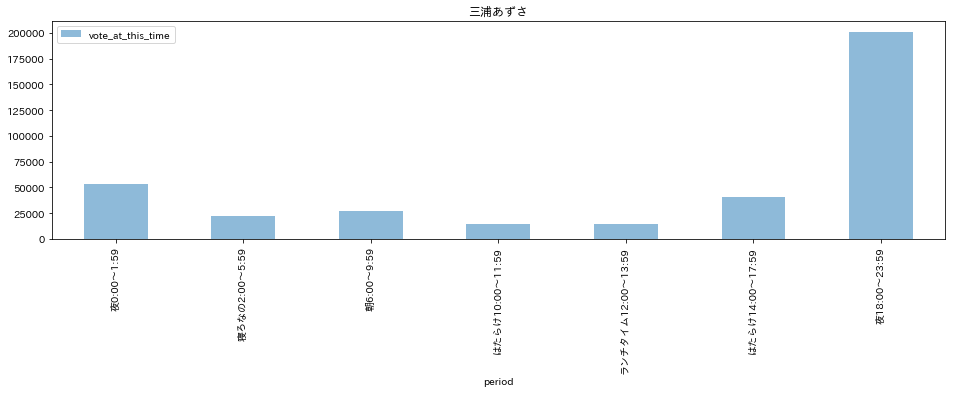

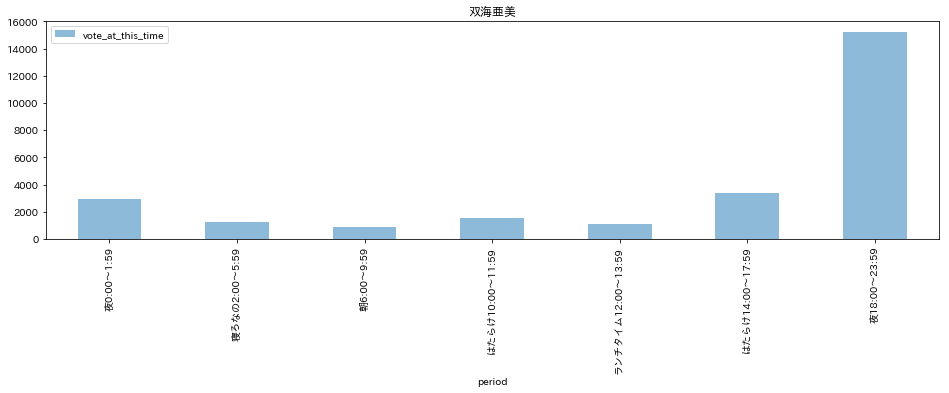

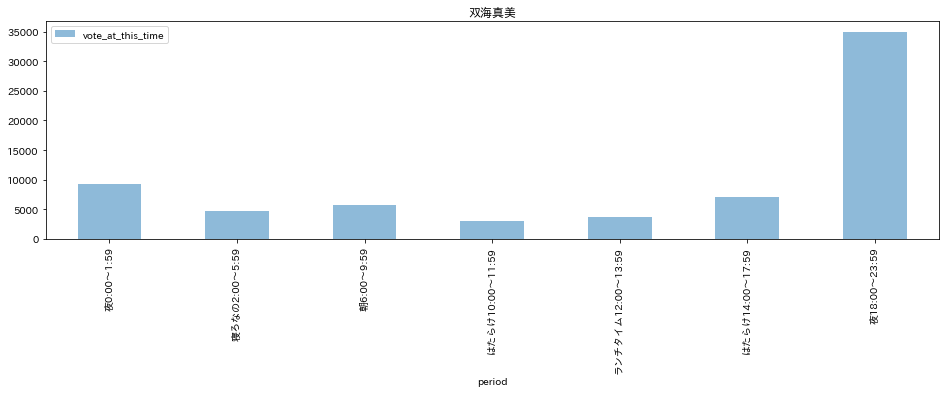

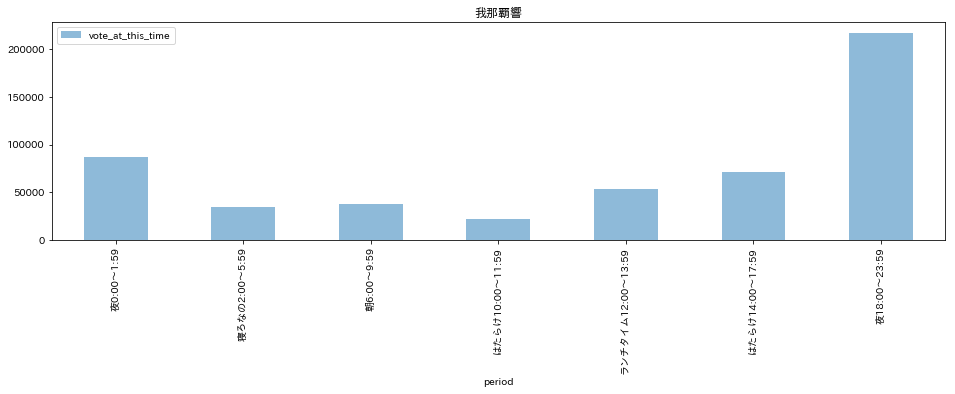

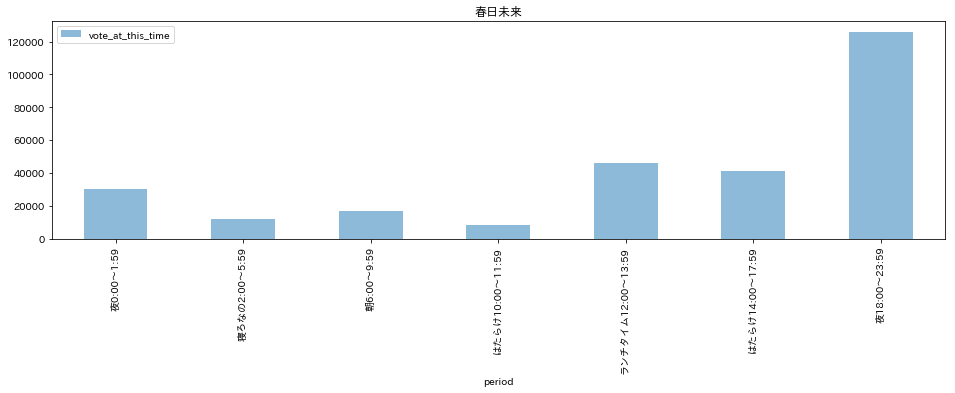

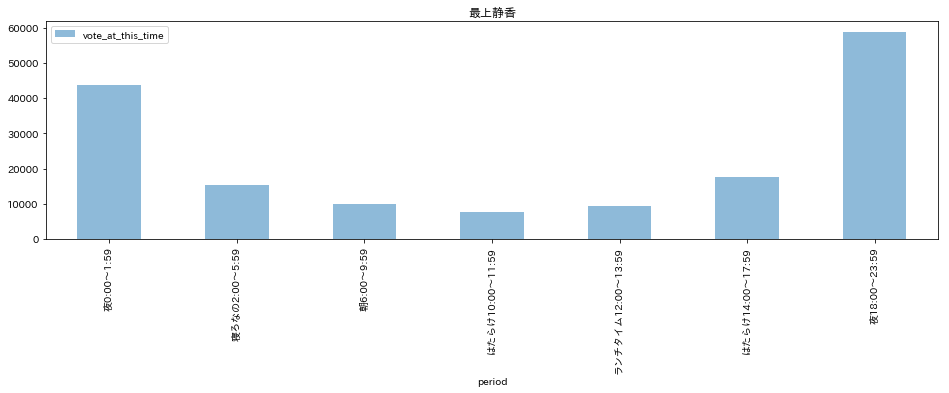

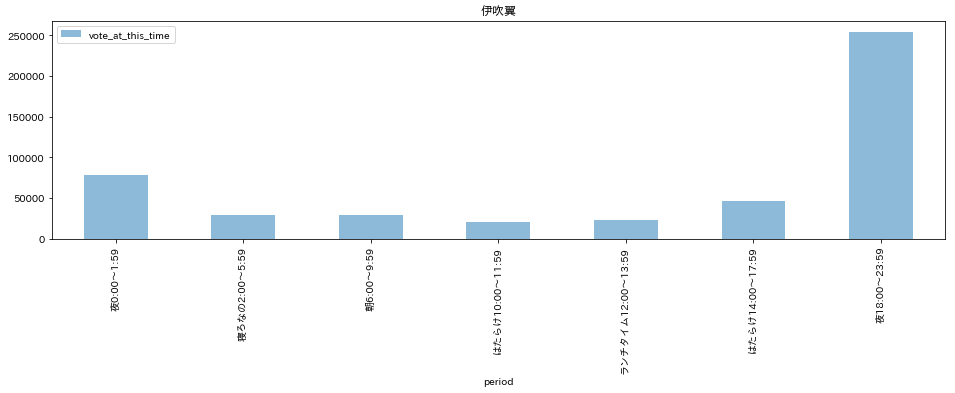

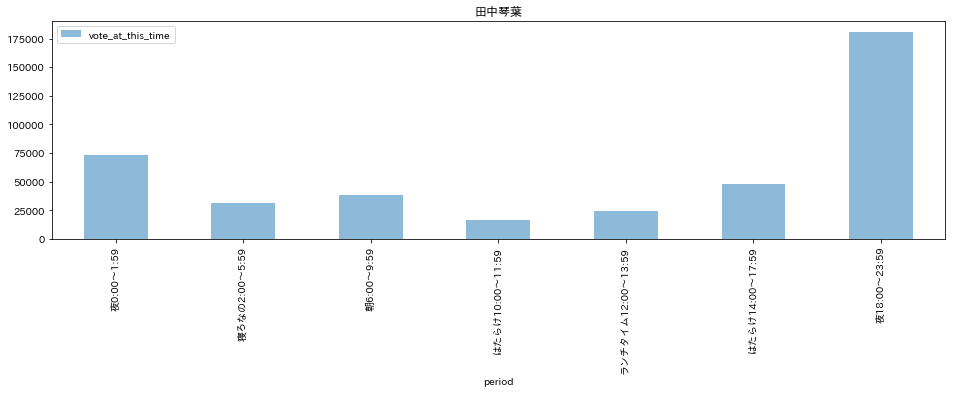

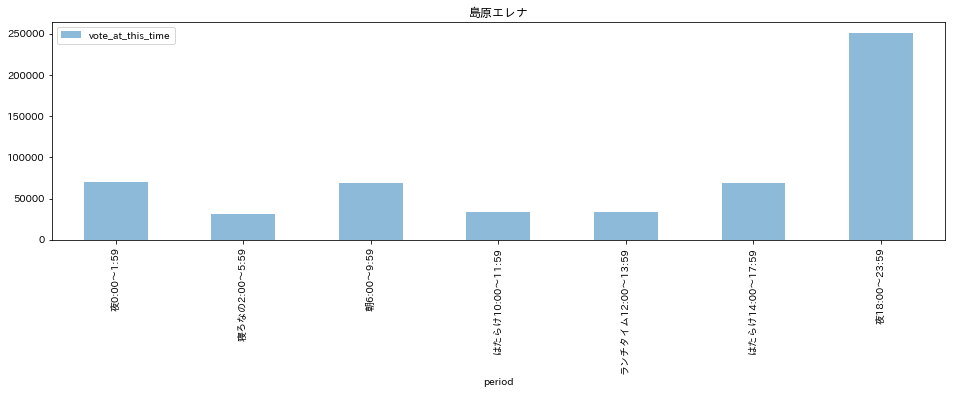

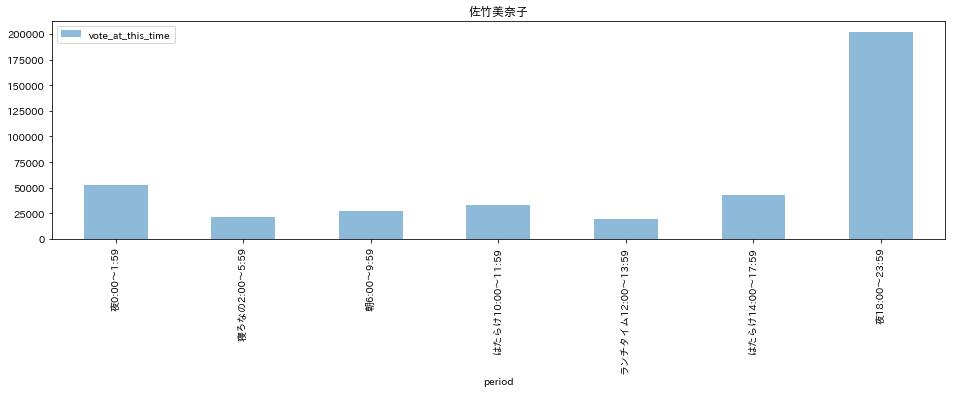

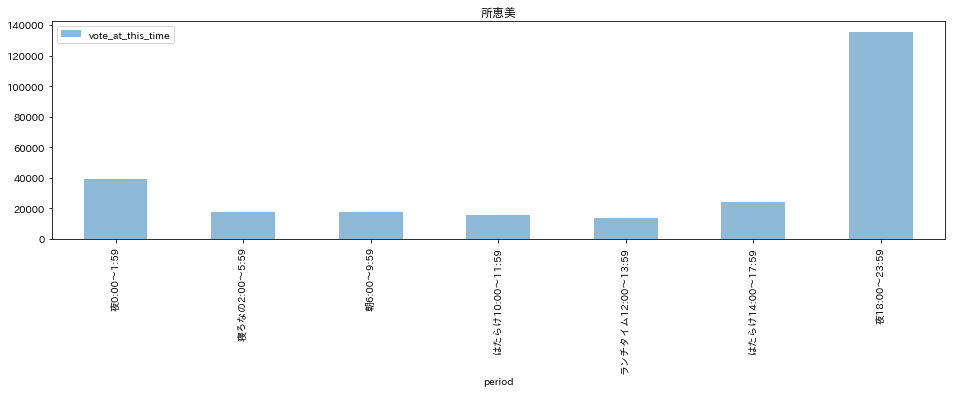

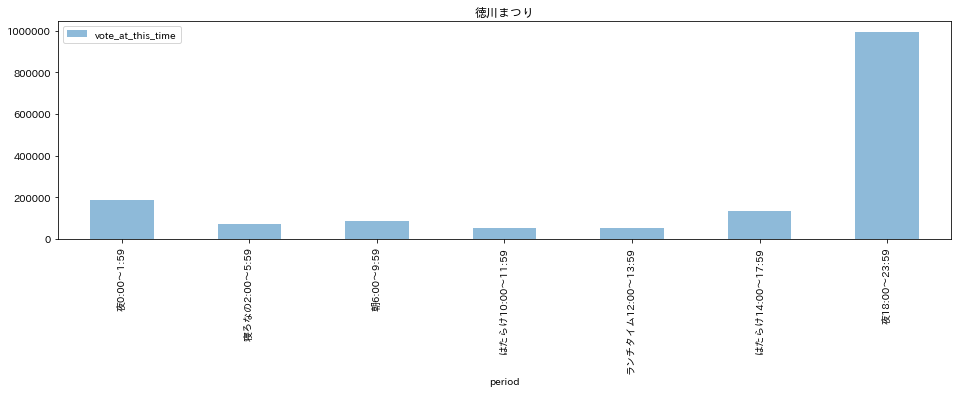

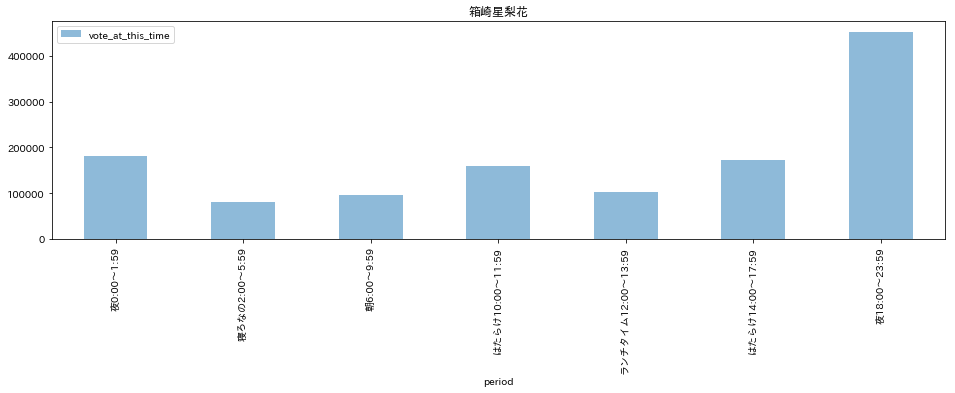

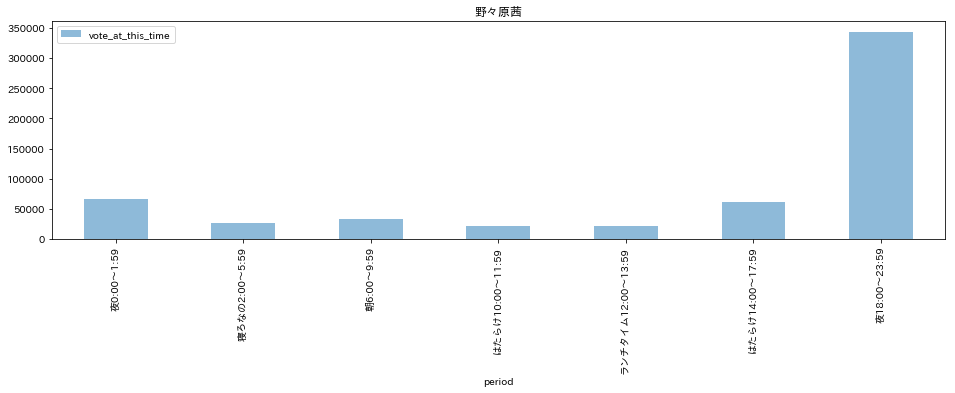

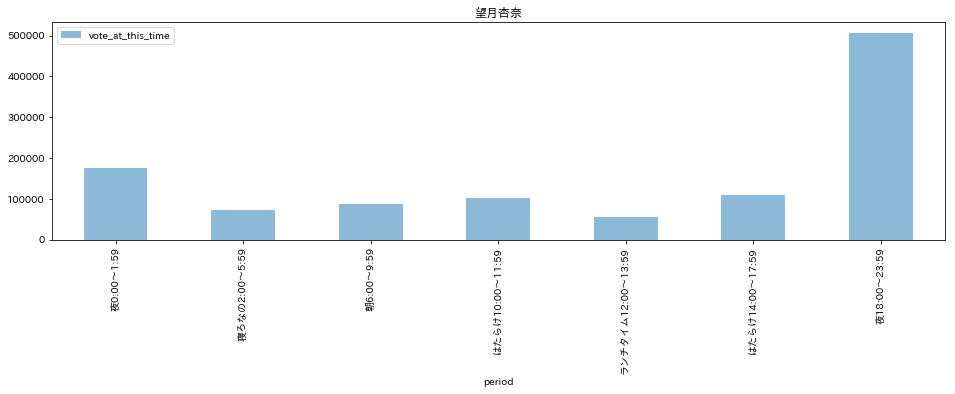

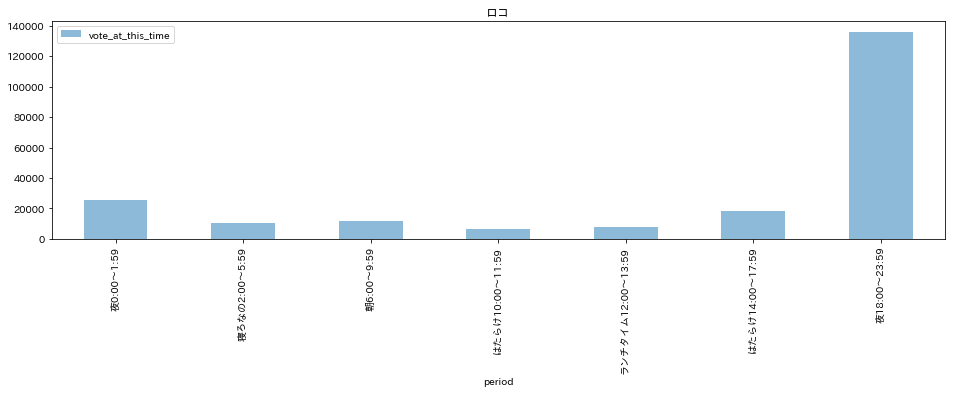

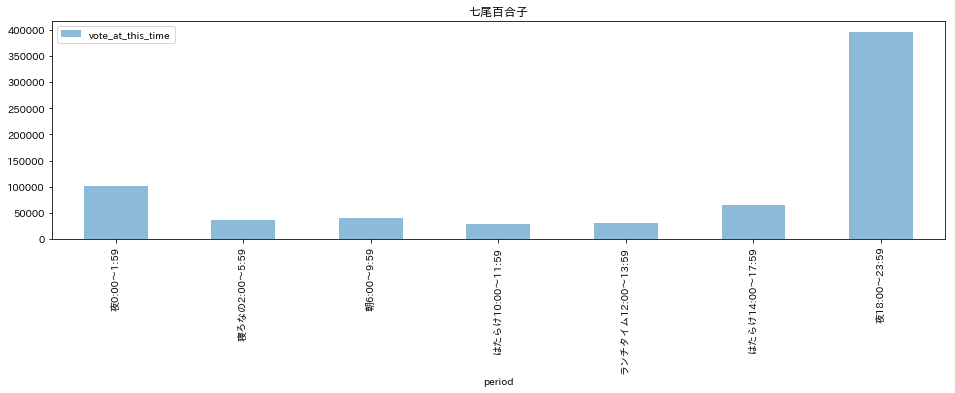

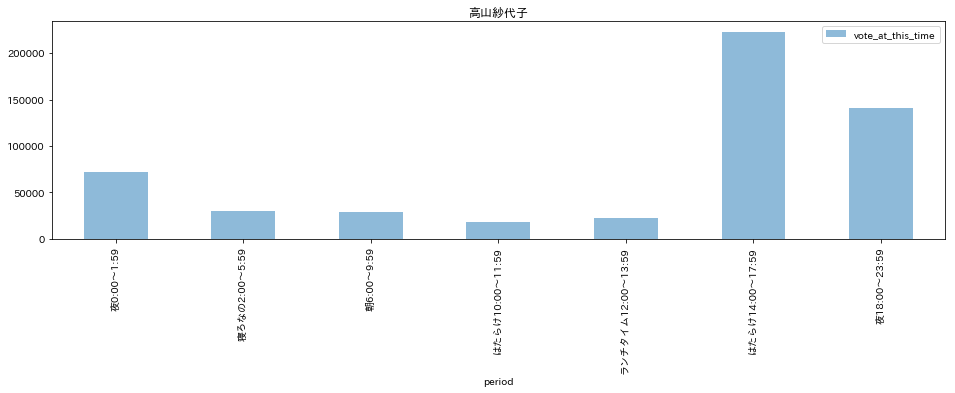

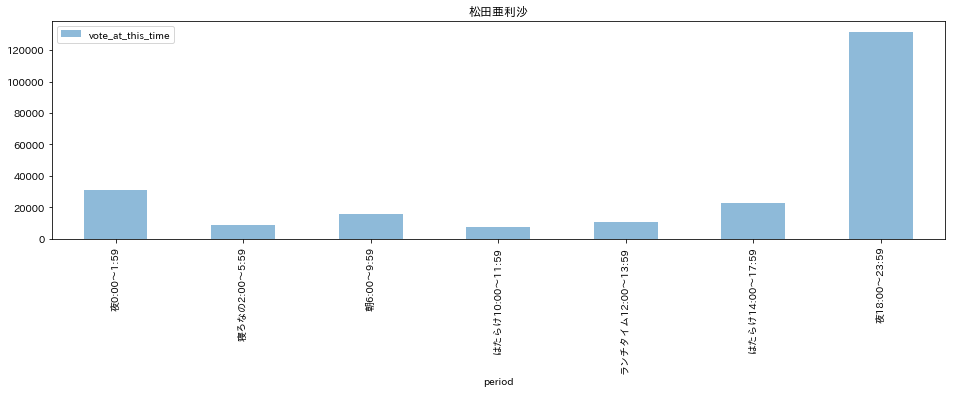

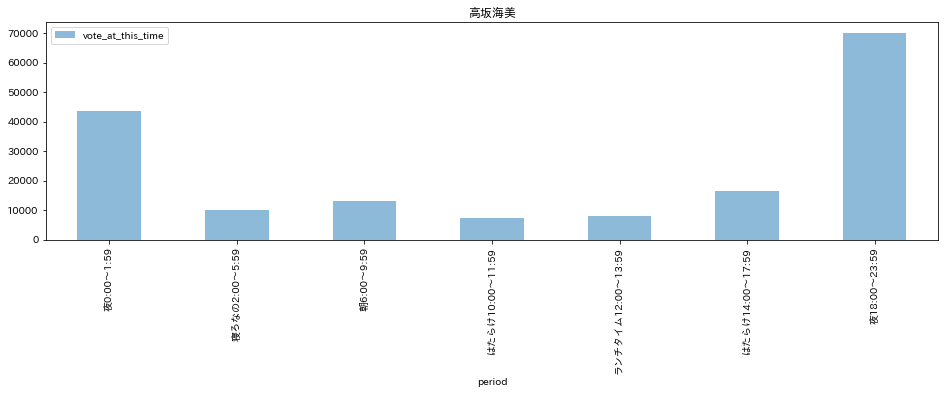

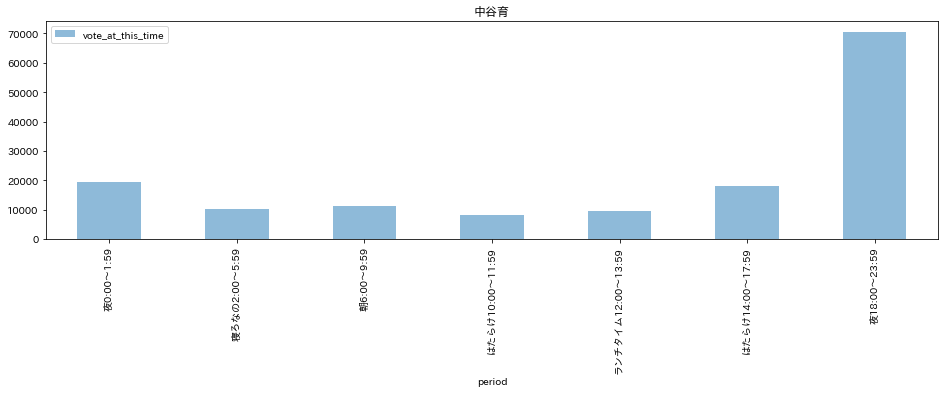

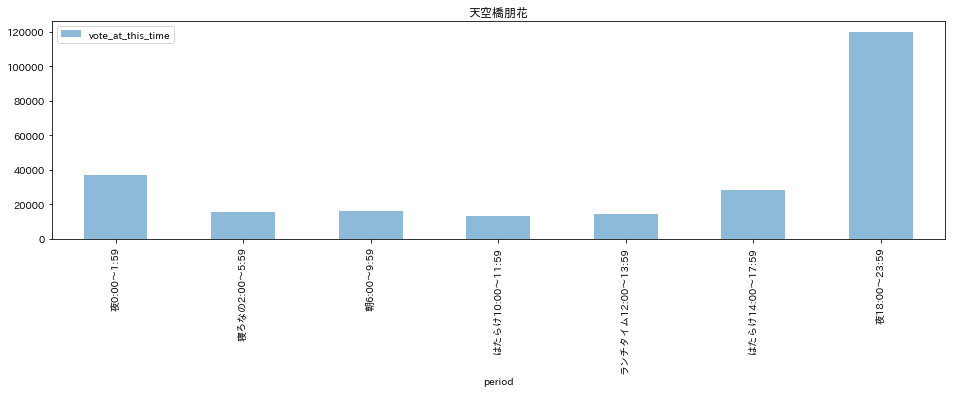

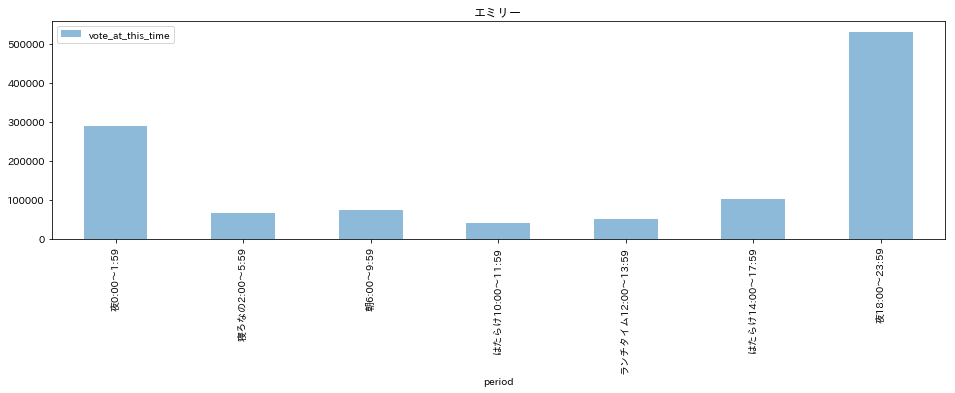

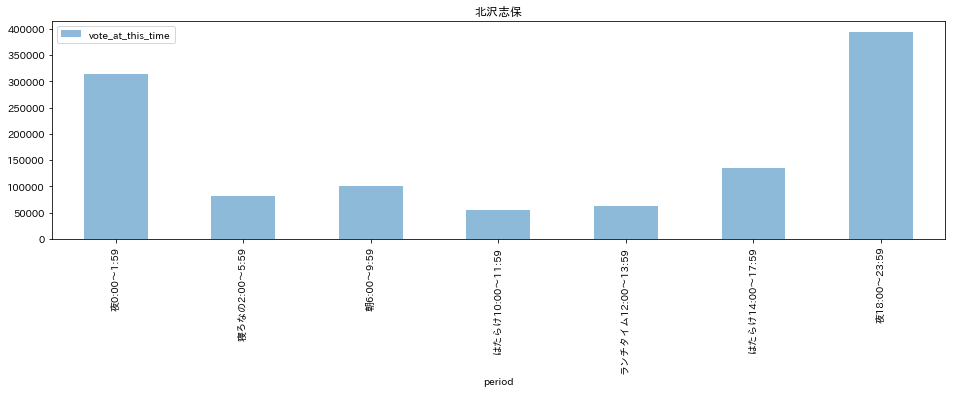

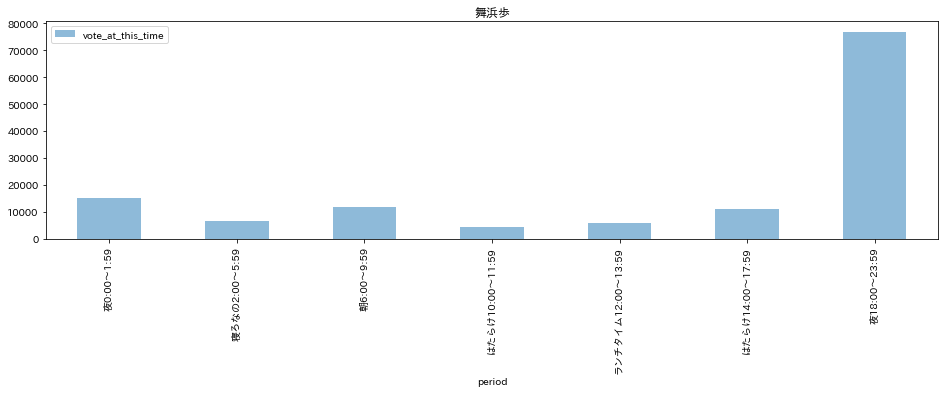

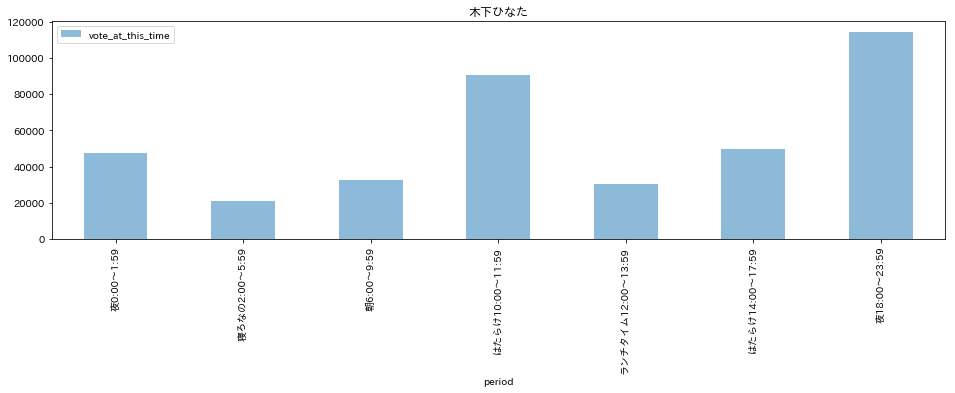

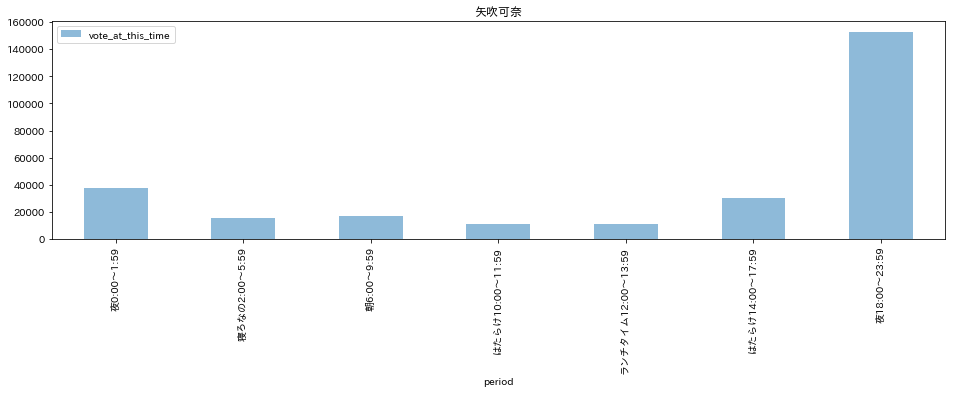

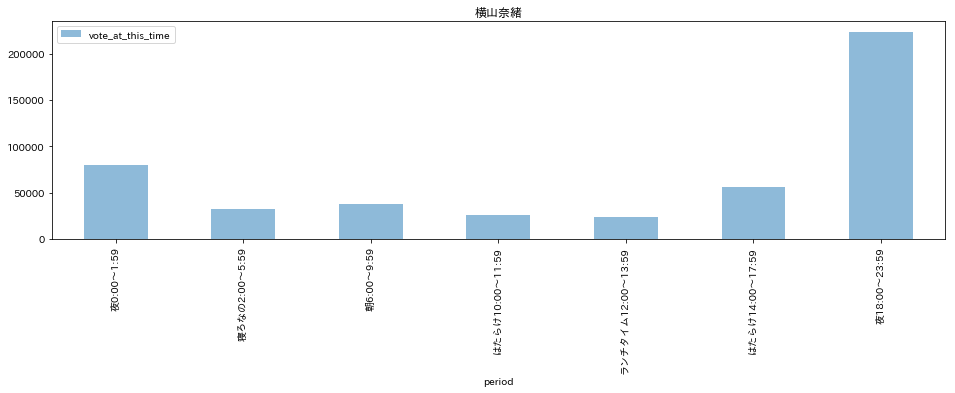

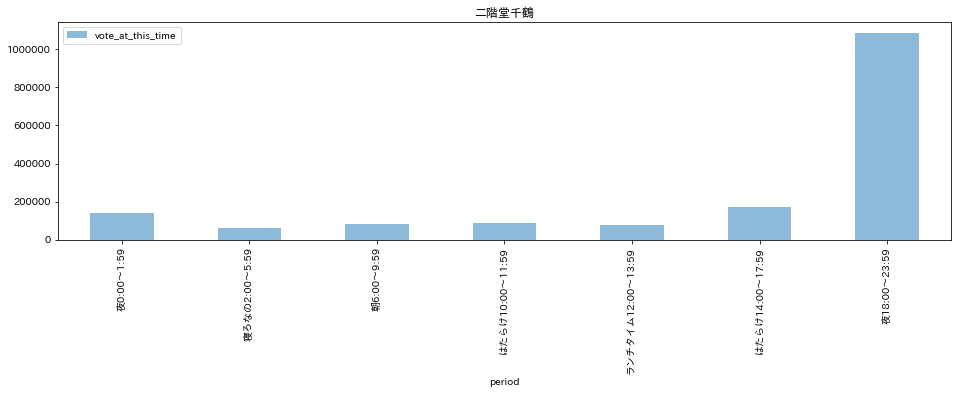

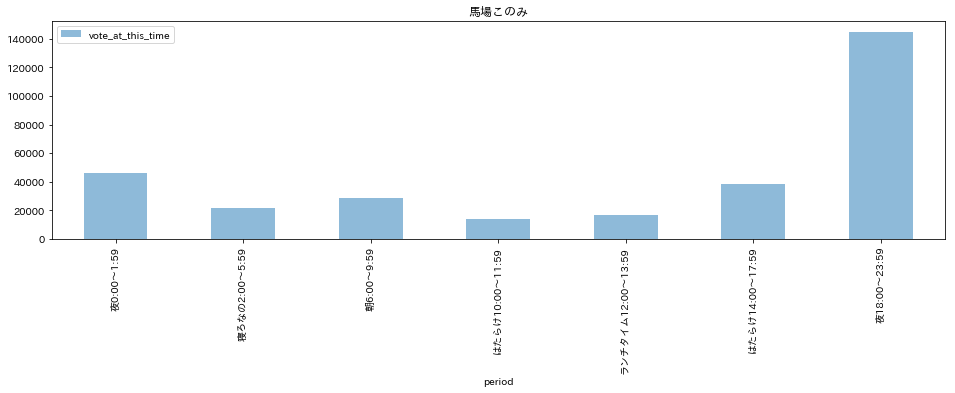

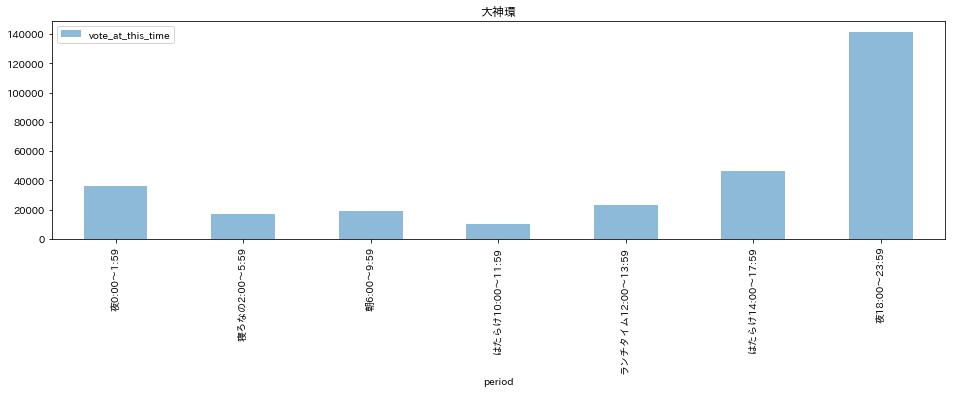

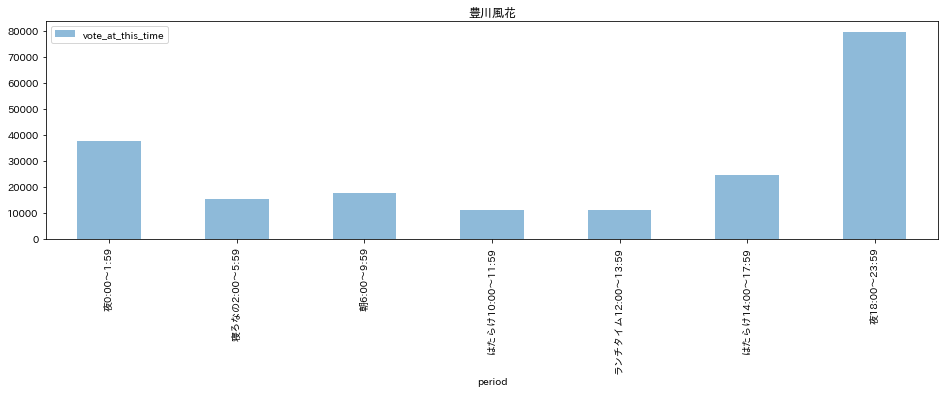

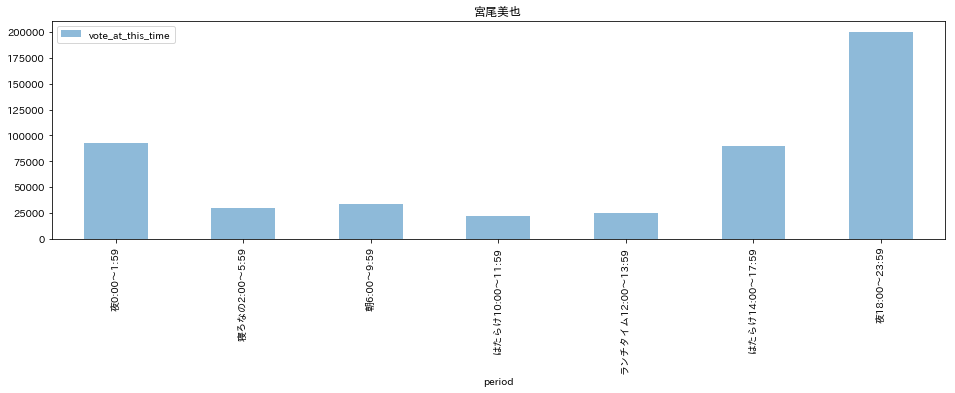

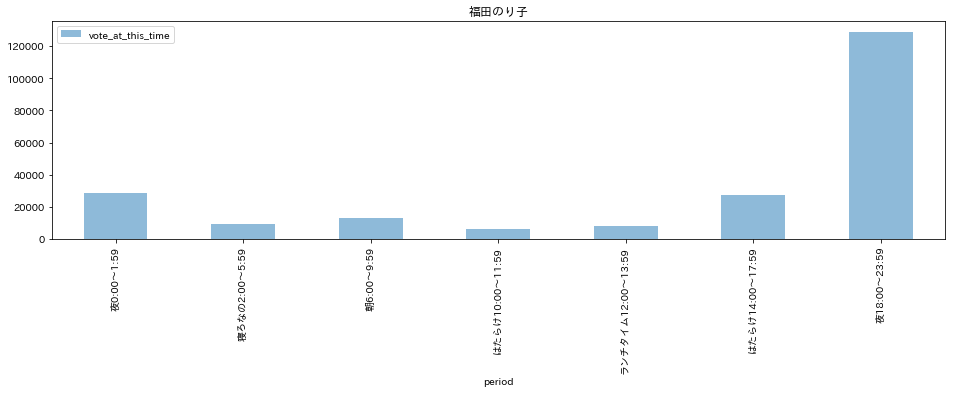

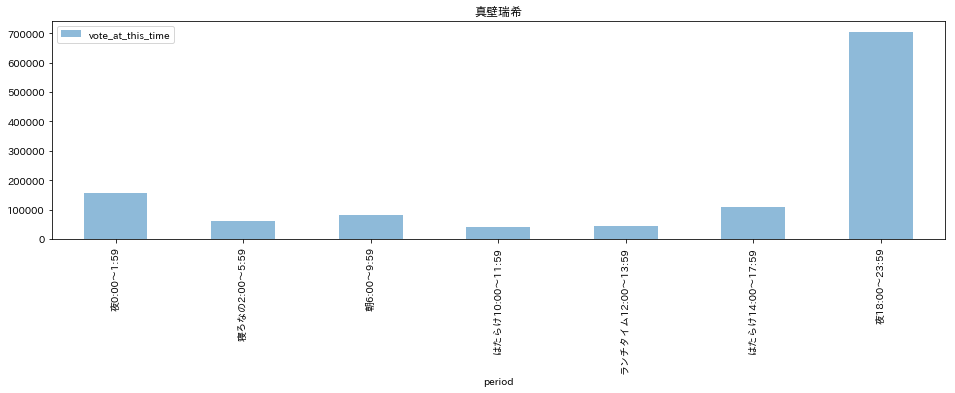

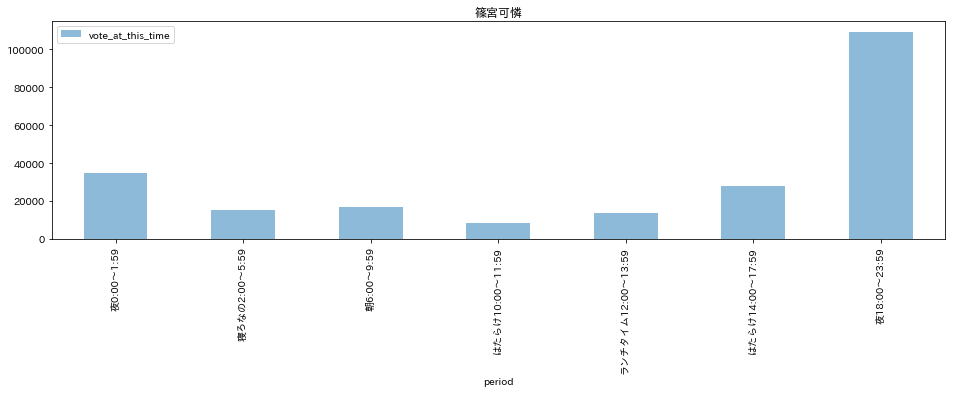

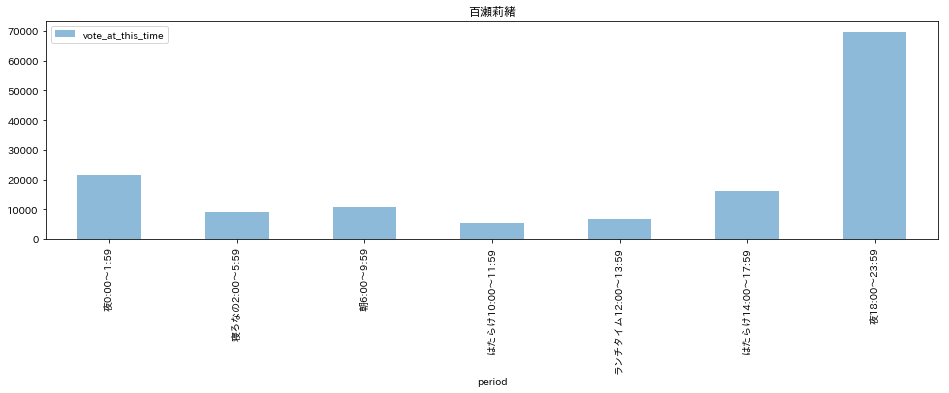

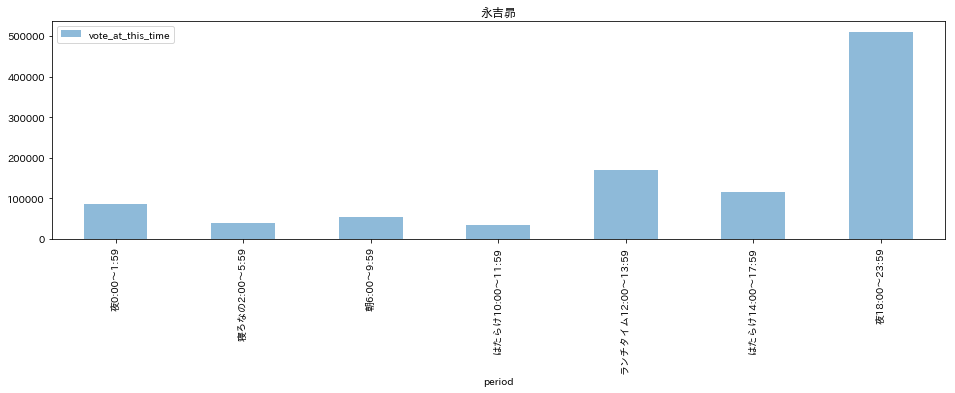

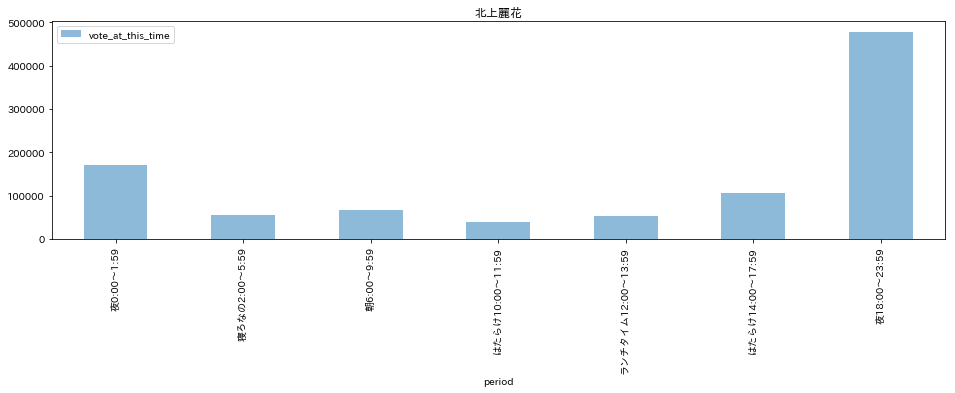

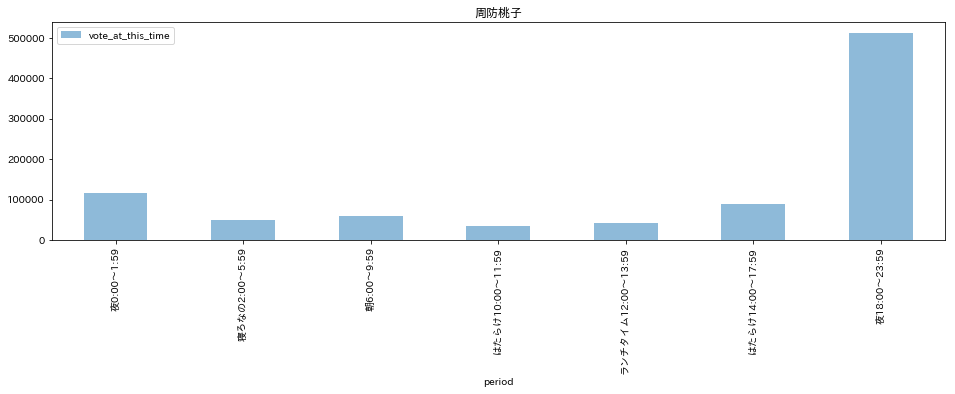

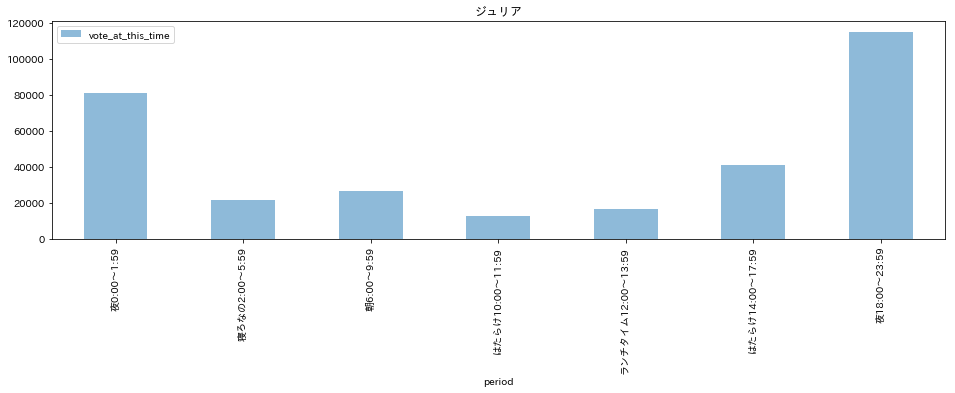

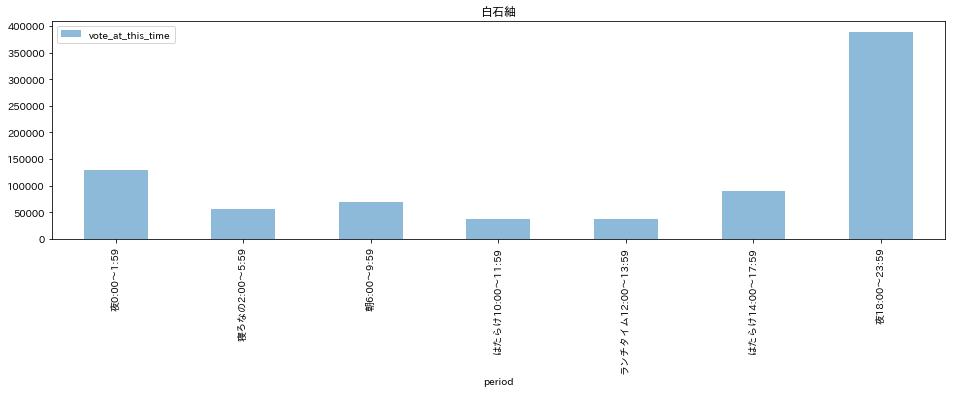

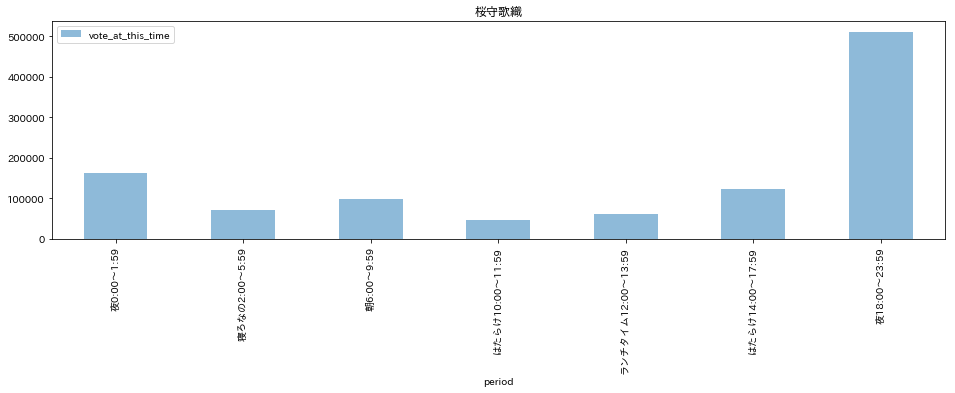

In [125]:
labels = ['夜0:00～1:59','寝ろなの2:00～5:59','朝6:00～9:59', 'はたらけ10:00～11:59', 'ランチタイム12:00～13:59', 'はたらけ14:00～17:59','夜18:00～23:59']
cols_neronano_hatarake = ['period', 'vote_at_this_time', 'idol']
df_neronano_hatarake = pd.DataFrame(index=[], columns=cols_neronano_hatarake)

##xsを使えば2列目のインデックスで取得できる
#reset_indexして再度インデックスをセットすればシングルインデックスになる
#アイドルIDごとに、何時に投票したか？をグラフ化
for id in df_idols.index :
    plot_data = df_vote_at_this_hour_allrole.xs([(id)],level=[1])
    plot_data['period'] = pd.cut(list(plot_data.index),  bins=[-1,1,5,9,11,13,17,23], labels=labels,right=True)  
    plot_data = pd.DataFrame(plot_data.groupby('period').sum())
    plot_data = pd.DataFrame(plot_data['vote_at_this_time'])
    plot_data.plot(kind='bar' , figsize=(16,4), alpha=0.5,title=dict_idols[id])
    plot_data['idol'] = id
    plot_data = plot_data.reset_index()
    df_neronano_hatarake = df_neronano_hatarake.append(plot_data)

## アイドル陣営ごとの就寝時間帯の投票率を計算したデータフレームを作成する

In [126]:
df_neronano = df_neronano_hatarake[df_neronano_hatarake["period"] == "寝ろなの2:00～5:59"].drop('period', axis=1).reset_index().drop('index', axis=1).set_index("idol")
cols_neronano_sum = ['idol','vote_at_this_time']
df_neronano_sum = pd.DataFrame(index=[], columns=cols_neronano_sum)

for id in df_idols.index :
    df_lines = df_neronano_hatarake[df_neronano_hatarake["idol"] == id]
    df_lines = pd.DataFrame(df_lines.groupby("idol").sum()).reset_index()
    df_neronano_sum = df_neronano_sum.append(df_lines)

df_neronano_sum = df_neronano_sum.set_index("idol")
df_neronano_sum = df_neronano_sum.rename(columns={'vote_at_this_time':'vote_at_this_time_all'})
df_neronanoritsu = df_neronano_sum.join(df_neronano)
df_neronanoritsu["寝ろなの率"] = df_neronanoritsu["vote_at_this_time"] / df_neronanoritsu["vote_at_this_time_all"] * 100



## 深夜投票率でソートしてインデックスをアイドル名に変更

In [127]:
df_neronanoritsu = df_neronanoritsu.sort_values(ascending=True,by='寝ろなの率')
df_neronanoritsu = df_neronanoritsu.reset_index()

df_neronanoritsu["idol"] = df_neronanoritsu["idol"].map(dict_idols)
df_neronanoritsu = df_neronanoritsu.set_index("idol")


## 最後にplot

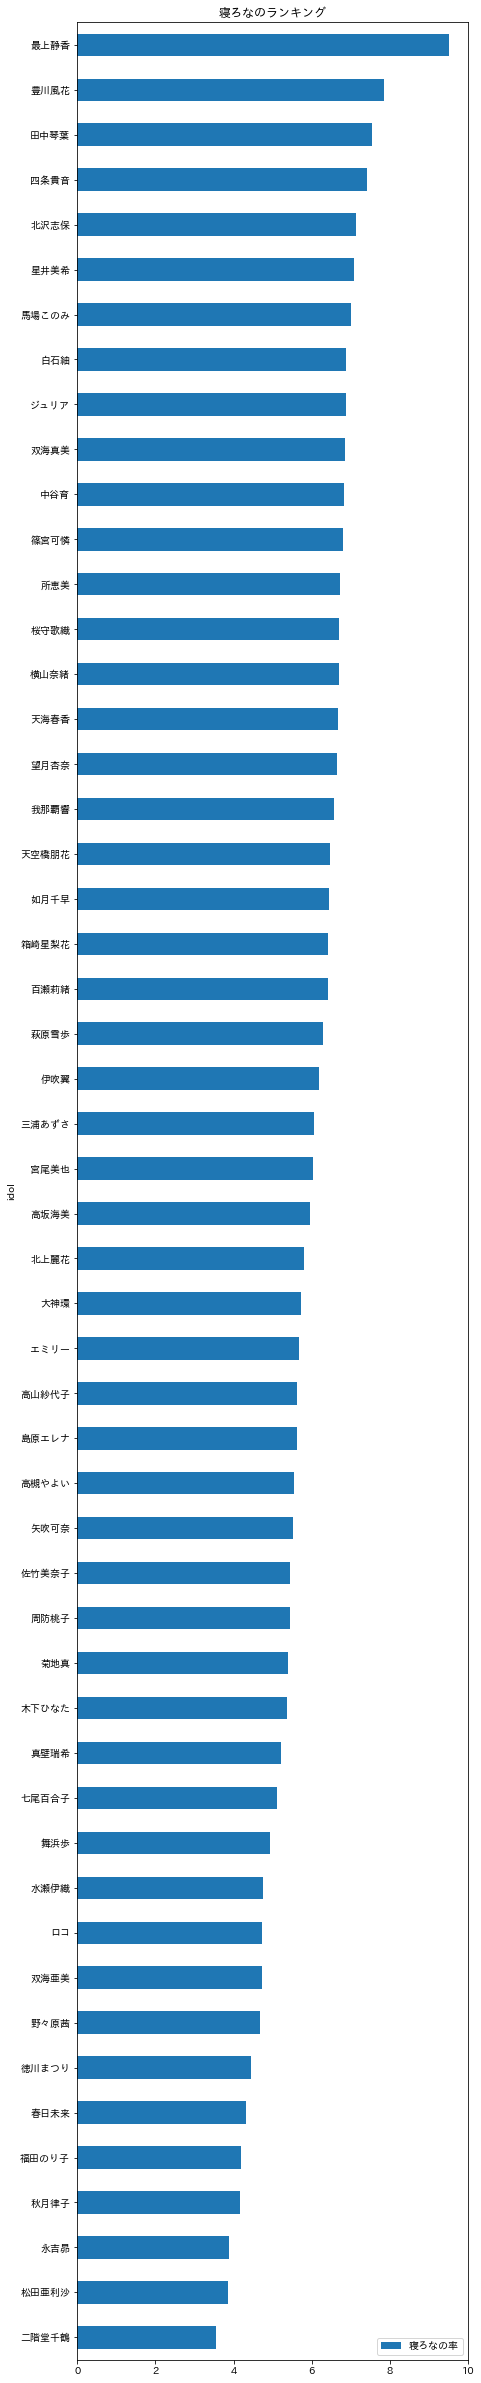

In [128]:
df_neronanoritsu.plot(kind='barh', y='寝ろなの率',figsize=(7,43),title='寝ろなのランキング')

## はたらけ時間帯の投票数を合算し、全体の投票数で割る

In [129]:
df_hatarakeAM = df_neronano_hatarake[df_neronano_hatarake["period"] == "はたらけ10:00～11:59"].drop('period', axis=1).reset_index().drop('index', axis=1).set_index("idol")
df_hatarakePM = df_neronano_hatarake[df_neronano_hatarake["period"] == "はたらけ14:00～17:59"].drop('period', axis=1).reset_index().drop('index', axis=1).set_index("idol")

df_hatarake_sum = pd.DataFrame(index=[], columns=cols_neronano_sum)

for id in df_idols.index :
    df_lines = df_neronano_hatarake[df_neronano_hatarake["idol"] == id]
    df_lines = pd.DataFrame(df_lines.groupby("idol").sum()).reset_index()
    df_hatarake_sum = df_hatarake_sum.append(df_lines)


df_hatarake_sum = df_hatarake_sum.set_index("idol")
df_hatarake_sum = df_hatarake_sum.rename(columns={'vote_at_this_time':'vote_at_this_time_all'})
df_hatarakePM = df_hatarakePM.rename(columns={'vote_at_this_time':'vote_at_this_time_pm'})
df_hatarakeAM = df_hatarakeAM.rename(columns={'vote_at_this_time':'vote_at_this_time_am'})
df_hatarakeritsu = df_hatarake_sum.join(df_hatarakeAM).join(df_hatarakePM)

df_hatarakeritsu["働いたら負けかなと思っている率"] = (df_hatarakeritsu["vote_at_this_time_am"] + df_hatarakeritsu["vote_at_this_time_pm"]) / df_hatarakeritsu["vote_at_this_time_all"] * 100


## 勤務コアタイム時間帯の投票率でソートしてインデックスをアイドル名に変更

In [130]:
df_hatarakeritsu = df_hatarakeritsu.sort_values(ascending=True,by='働いたら負けかなと思っている率')
df_hatarakeritsu = df_hatarakeritsu.reset_index()

df_hatarakeritsu["idol"] = df_hatarakeritsu["idol"].map(dict_idols)
df_hatarakeritsu = df_hatarakeritsu.set_index("idol")


## 最後にplot

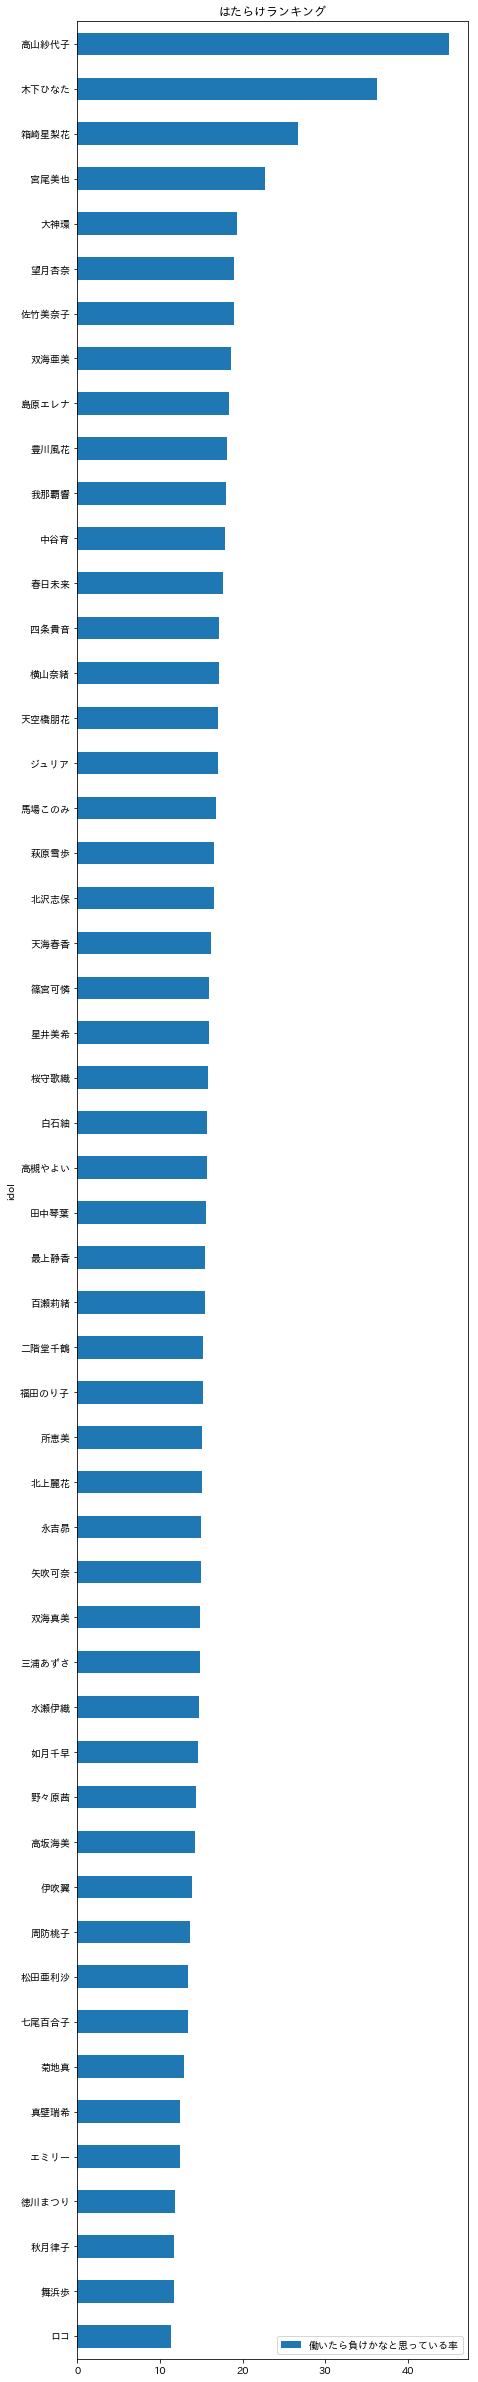

In [131]:
df_hatarakeritsu.plot(kind='barh', y='働いたら負けかなと思っている率',figsize=(7,43),title='はたらけランキング')